In [1]:
import torch
import torch.nn as nn
import torchmetrics
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
def evaluation_func(model, dataloader, metrics):
    model.eval()
    metrics.reset()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metrics.update(y_pred, y_batch)
        return metrics.compute()

def training_func(model, optimizer, loss_fn, metric, train_loader, val_loader, n_epochs, patience = 2, factor = 0.5, epoch_callback = None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience = patience, factor = factor
    )
    history = {'train_loss': [], 'train_metrics': [], 'val_metric': []}
    for epoch in range(n_epochs):
        model.train()
        metric.reset()
        train_loss = 0.0
        if epoch_callback is not None:
            epoch_callback(model,epoch)
        for index, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
            train_metric = metric.compute().item()
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_metrics'].append(train_metric)
        validated_metric = evaluation_func(model, val_loader, metric).item()
        history['val_metric'].append(validated_metric)
        scheduler.step(validated_metric)
        print(f'Epoch {epoch + 1} / {n_epochs}: Train Loss: {history['train_loss'][-1]: .4f}, Train Metric = {history['train_metrics'][-1]:.4f}, Valid Metric = {history["val_metric"][-1]:.4f}, Scheduler Best[{scheduler.best:.4f}]')
    return history

##### Performing PCA with an Undercomplete Linear Autoencoder

In [4]:
torch.manual_seed(42)
encoder = nn.Linear(3, 2)
decoder = nn.Linear(2, 3)
autoencoder = nn.Sequential(encoder, decoder).to(device)

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation

def generate_data(m, seed= 42):
    X = np.zeros((m, 3))
    rng = np.random.default_rng(seed)
    angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi
    X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5
    X += 0.28 * rng.standard_normal((m, 3))
    X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
    X += [0.2, 0, 0.2]
    return torch.from_numpy(X.astype(np.float32))

In [6]:
from torch.utils.data import DataLoader, TensorDataset

X_train = generate_data(60, seed=42)
X_val = generate_data(500, seed=1)
train_set = TensorDataset(X_train, X_train)
val_set = TensorDataset(X_val, X_val)
trainloader = DataLoader(train_set, batch_size= 32, shuffle=True)
validloader = DataLoader(val_set, batch_size= 32)

In [7]:
torch.manual_seed(42)
optimizer = torch.optim.NAdam(autoencoder.parameters(), lr = 0.2)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = training_func(autoencoder, optimizer, mse, rmse, trainloader, validloader, 20)

Epoch 1 / 20: Train Loss:  0.1621, Train Metric = 0.4057, Valid Metric = 0.3095, Scheduler Best[0.3095]
Epoch 2 / 20: Train Loss:  0.0697, Train Metric = 0.2636, Valid Metric = 0.2964, Scheduler Best[0.3095]
Epoch 3 / 20: Train Loss:  0.0644, Train Metric = 0.2531, Valid Metric = 0.3238, Scheduler Best[0.3238]
Epoch 4 / 20: Train Loss:  0.0935, Train Metric = 0.3028, Valid Metric = 0.4551, Scheduler Best[0.4551]
Epoch 5 / 20: Train Loss:  0.1088, Train Metric = 0.3359, Valid Metric = 0.2465, Scheduler Best[0.4551]
Epoch 6 / 20: Train Loss:  0.0415, Train Metric = 0.2027, Valid Metric = 0.2346, Scheduler Best[0.4551]
Epoch 7 / 20: Train Loss:  0.0426, Train Metric = 0.2046, Valid Metric = 0.2768, Scheduler Best[0.4551]
Epoch 8 / 20: Train Loss:  0.0470, Train Metric = 0.2184, Valid Metric = 0.2119, Scheduler Best[0.4551]
Epoch 9 / 20: Train Loss:  0.0314, Train Metric = 0.1790, Valid Metric = 0.2131, Scheduler Best[0.4551]
Epoch 10 / 20: Train Loss:  0.0300, Train Metric = 0.1739, Valid

In [8]:
codings = encoder(X_train.to(device))

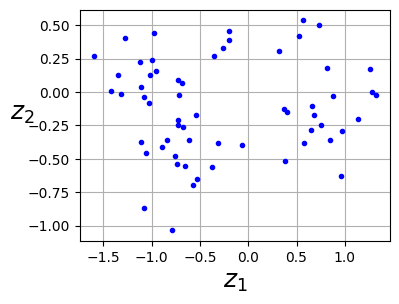

In [9]:
fig = plt.figure(figsize=(4,3))
codings_np = codings.cpu().detach().numpy()
plt.plot(codings_np[:,0], codings_np[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

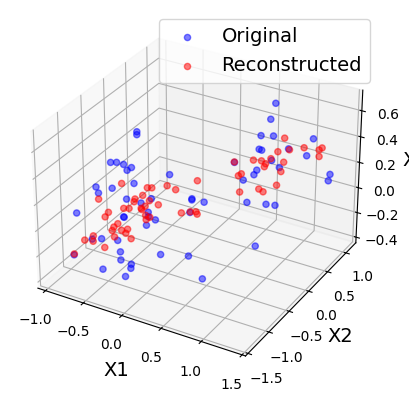

In [10]:
x_recon = decoder(codings)
#Plot 3D
autoencoder.eval()
with torch.no_grad():
    X_recon = autoencoder(X_train.to(device)).cpu().numpy()

X = X_train.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', alpha=0.5, label="Original")
ax.scatter(X_recon[:, 0], X_recon[:, 1], X_recon[:, 2],
           c='red', alpha=0.5, label="Reconstructed")

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend()
plt.show()


##### Stacked Autoencoder

In [11]:
torch.manual_seed(42)

stacked_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU()
)

stacked_decoder = nn.Sequential(
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28),
    nn.Sigmoid(),
    nn.Unflatten(dim = 1, unflattened_size=(1, 28, 28) )
)

stacked = nn.Sequential(
    stacked_encoder,
    stacked_decoder
).to(device)

In [12]:
import torchvision
import torchvision.transforms.v2 as transforms

toTensor = transforms.Compose([transforms.ToImage(),  transforms.ToDtype(torch.float32, scale=True)])
train_valid_data = torchvision.datasets.FashionMNIST(
    root ='datasets', train=True, download=True, transform=toTensor
)
test_data = torchvision.datasets.FashionMNIST(
    root ='datasets', train=False, download=True, transform=toTensor
)

In [13]:
torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_valid_data, [55000, 5000])

In [14]:
from torch.utils.data import Dataset

class AutoendcoderDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        return x, x
train_loader = DataLoader(AutoendcoderDataset(train_data), batch_size= 32, shuffle=True)
val_loader = DataLoader(AutoendcoderDataset(valid_data), batch_size= 32)
test_loader = DataLoader(AutoendcoderDataset(test_data), batch_size= 32)

In [15]:
optimizer = torch.optim.NAdam(stacked.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared= False).to(device)
history = training_func(stacked, optimizer, loss_fn, rmse, train_loader, val_loader, 20)

Epoch 1 / 20: Train Loss:  0.0267, Train Metric = 0.1634, Valid Metric = 0.1334, Scheduler Best[0.1334]
Epoch 2 / 20: Train Loss:  0.0162, Train Metric = 0.1273, Valid Metric = 0.1229, Scheduler Best[0.1334]
Epoch 3 / 20: Train Loss:  0.0141, Train Metric = 0.1188, Valid Metric = 0.1177, Scheduler Best[0.1334]
Epoch 4 / 20: Train Loss:  0.0129, Train Metric = 0.1135, Valid Metric = 0.1122, Scheduler Best[0.1334]
Epoch 5 / 20: Train Loss:  0.0120, Train Metric = 0.1093, Valid Metric = 0.1094, Scheduler Best[0.1334]
Epoch 6 / 20: Train Loss:  0.0116, Train Metric = 0.1079, Valid Metric = 0.1082, Scheduler Best[0.1334]
Epoch 7 / 20: Train Loss:  0.0114, Train Metric = 0.1067, Valid Metric = 0.1072, Scheduler Best[0.1334]
Epoch 8 / 20: Train Loss:  0.0111, Train Metric = 0.1052, Valid Metric = 0.1059, Scheduler Best[0.1334]
Epoch 9 / 20: Train Loss:  0.0110, Train Metric = 0.1047, Valid Metric = 0.1053, Scheduler Best[0.1334]
Epoch 10 / 20: Train Loss:  0.0109, Train Metric = 0.1043, Valid

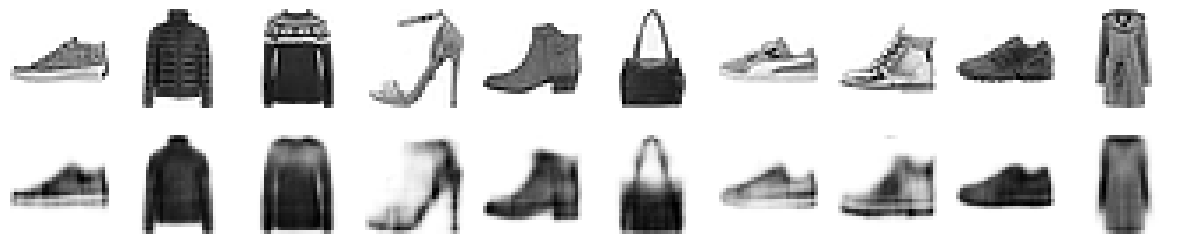

In [16]:
def plot_image(image):
    plt.imshow(image.permute(1,2,0).cpu(), cmap='binary')
    plt.axis('off')

def plot_reconstruction(model, images, n_image):
    images = images[:n_image]
    with torch.no_grad():
        y_pred = model(images.to(device))
    fig = plt.figure(figsize=(len(images) * 1.5, 3))
    for idx in range(len(images)):
        plt.subplot(2, len(images), idx + 1)
        plot_image(images[idx])
        plt.subplot(2, len(images), idx + 1 + len(images))
        plot_image(y_pred[idx])
x_val = torch.stack([x for x, _ in valid_data])
plot_reconstruction(stacked, x_val, 10)
plt.show()

##### Anomaly Detection With Autoencoders

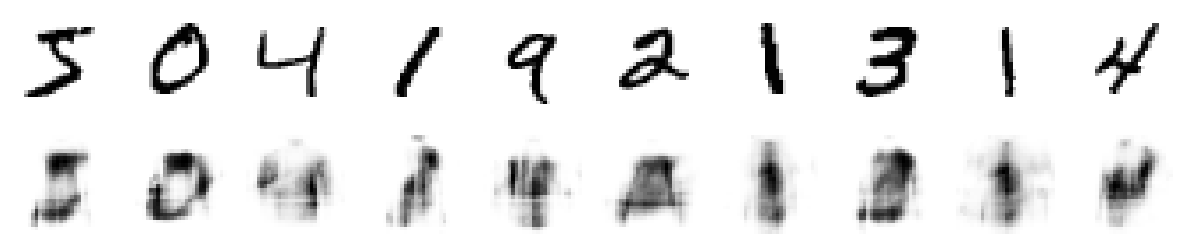

In [17]:
torch.manual_seed(42)
mnist_data = torchvision.datasets.MNIST(root='datasets', train=True, download=True, transform=toTensor)
mnist_image = torch.stack([mnist_data[i][0] for i in range(x_val.size(0))])
plot_reconstruction(stacked, mnist_image, 10)
plt.show()

In [18]:
images = mnist_image.to(device)
with torch.no_grad():
    y_pred = stacked(images)
    recon_loss = torch.nn.functional.mse_loss(y_pred, images)
recon_loss

tensor(0.0389, device='cuda:0')

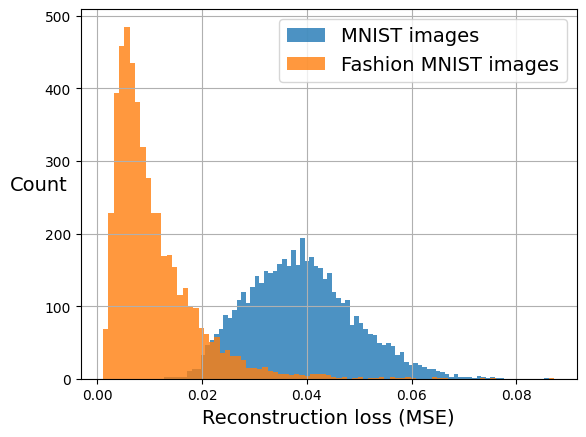

In [19]:
import torch.nn.functional as F
def compute_reconstruction_losses(X, device):
    X = X.to(device)
    with torch.no_grad():
        y_pred = stacked(X)
        return F.mse_loss(y_pred, X, reduction="none").view(X.size(0), -1).mean(dim=1).cpu()

recon_losses_mnist = compute_reconstruction_losses(mnist_image, device)
recon_losses_fashion_mnist = compute_reconstruction_losses(x_val, device)

plt.hist(recon_losses_mnist, bins=85, alpha=0.8, label="MNIST images")
plt.hist(recon_losses_fashion_mnist, bins=85, alpha=0.8, label="Fashion MNIST images")
plt.xlabel("Reconstruction loss (MSE)")
plt.ylabel("Count", rotation=0)
plt.legend()
plt.grid()

plt.show()

##### Using Autoencoder for dim reduction

In [20]:
from sklearn.manifold import TSNE

with torch.no_grad():
    x_val_compressed = stacked_encoder(x_val.to(device))
tsne = TSNE(init='pca', random_state=42)
x_val_2d = tsne.fit_transform(x_val_compressed.cpu())

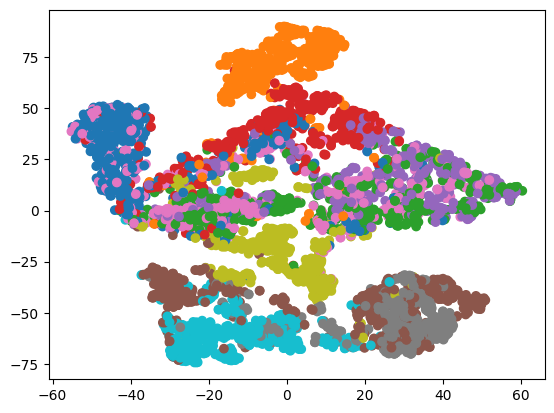

In [21]:
y_val = torch.tensor([y for _, y in valid_data])
plt.scatter(x_val_2d[:, 0], x_val_2d[:, 1], c=y_val, cmap='tab10')
plt.show()

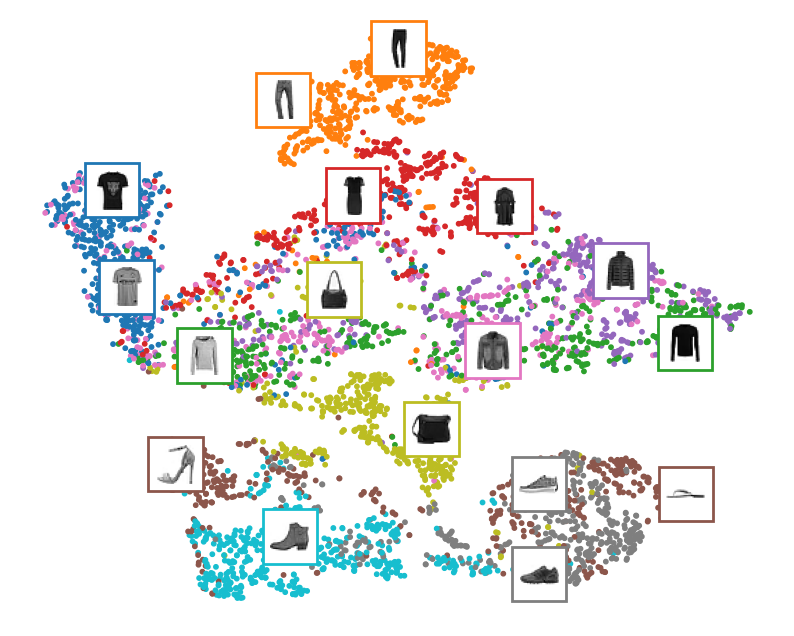

In [22]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = x_val_2d
Z = (Z - Z.min()) / (Z.max() - Z.min())
plt.scatter(Z[:, 0], Z[:, 1], c=y_val, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_val[index].squeeze(dim=0),
                                      cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_val[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")

plt.show()


##### Tying  (tie the weights of the decoder layers to the weights of the encoder layer)

In [23]:
class TiedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder1 = nn.Linear(1 * 28 * 28, 128)
        self.encoder2 = nn.Linear(128, 32)
        self.decoder_bias = nn.Parameter(torch.zeros(128))
        self.decoder_bias2 = nn.Parameter(torch.zeros(1 * 28 * 28))

    def encode(self, X):
        Z = X.view(-1, 1 * 28 * 28)
        Z = F.relu(self.encoder1(Z))
        return F.relu(self.encoder2(Z))

    def decode(self, X):
        Z = F.relu(F.linear(X, self.encoder2.weight.t(), self.decoder_bias))
        Z = F.sigmoid(F.linear(Z, self.encoder1.weight.t(), self.decoder_bias2))
        return Z.view(-1, 1, 28, 28)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.decode(self.encode(x))

In [24]:
tied_model = TiedAutoencoder().to(device)
optimizer = torch.optim.NAdam(tied_model.parameters(), lr= 0.01)
history = training_func(tied_model, optimizer, loss_fn, rmse, train_loader, val_loader, 20)

Epoch 1 / 20: Train Loss:  0.0229, Train Metric = 0.1514, Valid Metric = 0.1382, Scheduler Best[0.1382]
Epoch 2 / 20: Train Loss:  0.0174, Train Metric = 0.1319, Valid Metric = 0.1340, Scheduler Best[0.1382]
Epoch 3 / 20: Train Loss:  0.0166, Train Metric = 0.1290, Valid Metric = 0.1320, Scheduler Best[0.1382]
Epoch 4 / 20: Train Loss:  0.0162, Train Metric = 0.1274, Valid Metric = 0.1261, Scheduler Best[0.1382]
Epoch 5 / 20: Train Loss:  0.0142, Train Metric = 0.1191, Valid Metric = 0.1204, Scheduler Best[0.1382]
Epoch 6 / 20: Train Loss:  0.0139, Train Metric = 0.1177, Valid Metric = 0.1180, Scheduler Best[0.1382]
Epoch 7 / 20: Train Loss:  0.0136, Train Metric = 0.1168, Valid Metric = 0.1179, Scheduler Best[0.1382]
Epoch 8 / 20: Train Loss:  0.0128, Train Metric = 0.1131, Valid Metric = 0.1141, Scheduler Best[0.1382]
Epoch 9 / 20: Train Loss:  0.0127, Train Metric = 0.1125, Valid Metric = 0.1135, Scheduler Best[0.1382]
Epoch 10 / 20: Train Loss:  0.0125, Train Metric = 0.1119, Valid

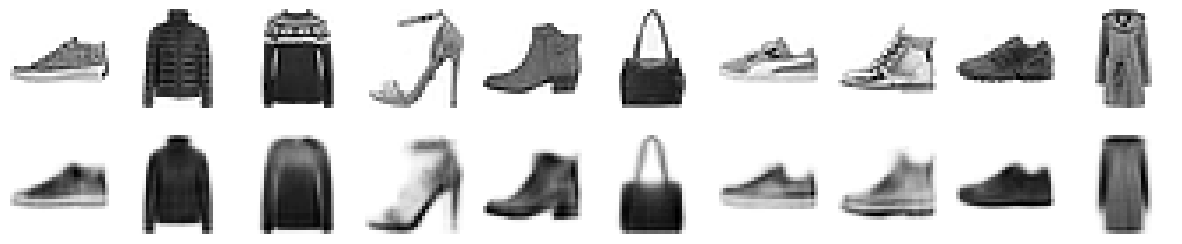

In [25]:
plot_reconstruction(tied_model, x_val, 10)

##### Convolutional Autoencoder

In [37]:
convo_encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(128, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)

convo_decoder = nn.Sequential(
    nn.Linear(32, 16 * 3 * 3),
    nn.Unflatten(dim = 1, unflattened_size=(16, 3, 3) ),
    nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding= 1, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding= 1, output_padding=1),
    nn.Sigmoid(),
)

convo_ae = nn.Sequential(convo_encoder, convo_decoder).to(device)

In [38]:
optimizer = torch.optim.NAdam(convo_ae.parameters(), lr=0.005)
history = training_func(convo_ae, optimizer, mse, rmse, train_loader, val_loader,
                n_epochs=10)

Epoch 1 / 10: Train Loss:  0.0317, Train Metric = 0.1780, Valid Metric = 0.1470, Scheduler Best[0.1470]
Epoch 2 / 10: Train Loss:  0.0197, Train Metric = 0.1403, Valid Metric = 0.1351, Scheduler Best[0.1470]
Epoch 3 / 10: Train Loss:  0.0175, Train Metric = 0.1322, Valid Metric = 0.1297, Scheduler Best[0.1470]
Epoch 4 / 10: Train Loss:  0.0164, Train Metric = 0.1280, Valid Metric = 0.1257, Scheduler Best[0.1470]
Epoch 5 / 10: Train Loss:  0.0148, Train Metric = 0.1217, Valid Metric = 0.1219, Scheduler Best[0.1470]
Epoch 6 / 10: Train Loss:  0.0146, Train Metric = 0.1207, Valid Metric = 0.1206, Scheduler Best[0.1470]
Epoch 7 / 10: Train Loss:  0.0143, Train Metric = 0.1196, Valid Metric = 0.1203, Scheduler Best[0.1470]
Epoch 8 / 10: Train Loss:  0.0138, Train Metric = 0.1174, Valid Metric = 0.1184, Scheduler Best[0.1470]
Epoch 9 / 10: Train Loss:  0.0137, Train Metric = 0.1170, Valid Metric = 0.1181, Scheduler Best[0.1470]
Epoch 10 / 10: Train Loss:  0.0136, Train Metric = 0.1166, Valid

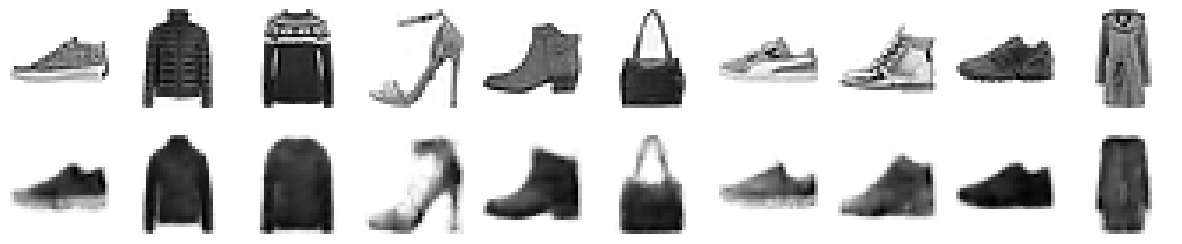

In [39]:
plot_reconstruction(convo_ae, x_val, 10)
plt.show()